In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])
## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'physicalConstants', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [3]:
compset = 'FAMIPC5'
experiment = 'piControl'
subset = 'tropics'
time_stride = 'day'

historyFilesSettings = getCAMHistoryFilesSettings()

inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

daskarray = True
    
q_id = 'Q'
spechum = getValues(q_id,compset,subset,experiment,time_stride,daskarray=daskarray)
omega_id = 'OMEGA'
omega = getValues(omega_id,compset,subset,experiment,time_stride,daskarray=daskarray)
pr_id = 'PRECT'
pr = getValues(pr_id,compset,subset,experiment,time_stride,daskarray=daskarray)
ts_id = 'TS'
ts = getValues(ts_id,compset,subset,experiment,time_stride,daskarray=daskarray)
relhum_id = 'RELHUM'
relhum = getValues(relhum_id,compset,subset,experiment,time_stride,daskarray=daskarray)


Q found in history files
Importing Q from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc
OMEGA found in history files
Importing OMEGA from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc
PRECT found in history files
Importing PRECT from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc
TS found in history files
Importing TS from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  

In [4]:
## Get longitude, latitude and landmask

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)

print("Loading lontigude, latitude and landmask")

landmask = fh.variables['landmask']


Loading lontigude, latitude and landmask


In [5]:
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)

In [11]:
ps_varid = 'PS'
ps = getValues(ps_varid,compset,subset,experiment,time_stride,daskarray=daskarray)
pres = computeP(ps)
cn = getArrayType(pres)

PS found in history files
Importing PS from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc


In [12]:
pr_est = verticalPressureIntegral(pres,values=[omega_pos],dvdp=dq_dp,levdim=levdim)

In [13]:
levdim = 1 
omega_pos = omega.copy()
omega_pos[omega > 0] = 0
dq = cn.diff(spechum,axis=levdim)
dp = cn.diff(pres,axis=levdim) 
dq_dp = dq/dp

In [14]:
pr_est.max().compute()
pr.max().compute()

7.953401e-07

(-0.0001, 0.0001)

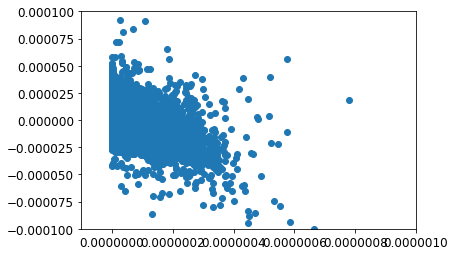

In [15]:
plt.scatter(pr,pr_est)
plt.xlim((-1e-7,1e-6))
plt.ylim((-1e-4,1e-4))